In [1]:
import torch
torch.manual_seed(2024)
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

In [2]:
# np.random.seed(2024)
# from sklearn import datasets
# iris = datasets.load_iris()
# randomized_indices = np.random.permutation(iris['target'].shape[0])
# iris['data'] = iris['data'][randomized_indices, :].astype(np.float32)
# iris['target'] = iris['target'][randomized_indices]

# train_x = torch.tensor(iris['data'][:40, :])
# train_y = torch.tensor(iris['target'][:40])
# test_x = torch.tensor(iris['data'][40:, :])
# test_y = torch.tensor(iris['target'][40:])
# mean_x = torch.mean(train_x, axis = 0)
# std_x = torch.std(train_x, axis = 0)
# train_x = (train_x - mean_x)/std_x
# test_x = (test_x - mean_x)/std_x

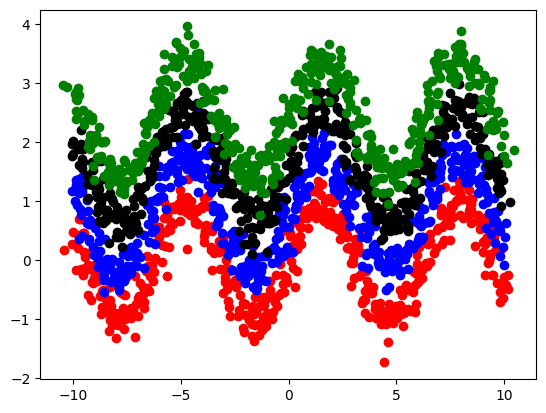

In [3]:
# Generate classification data for experiment purpose

np.random.seed(2024)
# x1 = np.random.randn(500, 2)
# x2 = np.random.randn(500, 2)
# x3 = np.random.randn(500, 2)
# x4 = np.random.randn(500, 2)
# x1 = x1 / 1.8
# x1[:, 0] += 0.5
# x2 = 3*x2 / (np.expand_dims(np.sqrt(x2[:, 0]**2 + x2[:,1 ]**2), 1)) + np.random.randn(500, 2)*0.4
# x3 = 2*x3 / (np.expand_dims(np.sqrt(x3[:, 0]**2 + x3[:,1 ]**2), 1)) + np.random.randn(500, 2)*0.4
# x4 = 4*x4 / (np.expand_dims(np.sqrt(x4[:, 0]**2 + x4[:,1 ]**2), 1)) + np.random.randn(500, 2)*0.4

xx = np.zeros((500, 2))
xx[:, 0] = np.linspace(-10, 10, 500)
xx[:, 1] = np.sin(np.linspace(-10, 10, 500))

x1 = xx + np.random.randn(500, 2)*0.2
x2 = xx + np.random.randn(500, 2)*0.2
x3 = xx + np.random.randn(500, 2)*0.2
x4 = xx + np.random.randn(500, 2)*0.2
x2[:, 1] += 0.8
x3[:, 1] += 1.6
x4[:, 1] += 2.4

plt.scatter(x1[:,0], x1[:,1], color='r')
plt.scatter(x2[:,0], x2[:,1], color='b')
plt.scatter(x3[:,0], x3[:,1], color='k')
plt.scatter(x4[:,0], x4[:,1], color='g')
plt.show()

x = np.concatenate((x1, x2, x3, x4), axis=0).astype(np.float32)
x = x / np.max(np.abs(x))
y = np.ones((2000, )).astype(np.int_)
y[:500] = 0
y[1000:] = 2
y[1500:] = 3

randomized_indices = np.random.permutation(2000)
x = x[randomized_indices, :]
y = y[randomized_indices]
train_x = x[:1500, :]
train_y = y[:1500]
test_x = x[1500:, :]
test_y = y[1500:]
mean_x = np.mean(train_x, 0)
std_x = np.std(train_x, 0)

In [4]:
print(test_y)

[2 0 0 2 3 0 1 3 0 3 3 0 1 0 2 2 3 0 1 3 1 1 2 2 2 1 2 0 1 2 0 2 3 1 1 2 2
 2 3 0 0 3 3 1 0 1 1 1 1 3 1 1 1 0 3 0 2 3 1 2 3 1 2 3 1 1 3 3 2 1 2 1 1 2
 1 3 1 3 2 1 2 1 0 2 0 3 1 0 2 3 3 1 3 3 3 2 3 3 1 1 3 3 1 0 1 1 1 2 0 1 0
 3 0 3 1 3 2 3 1 3 2 2 2 1 2 1 2 0 2 0 0 3 1 3 2 3 2 3 3 0 3 3 2 1 1 0 0 1
 2 0 3 2 0 3 0 0 2 1 3 1 3 0 2 0 0 2 1 1 1 0 1 1 3 3 3 3 0 1 0 2 3 3 2 2 1
 2 2 1 0 2 3 0 1 2 1 2 0 1 2 1 0 2 3 1 3 1 3 1 3 3 1 1 2 2 3 3 1 3 0 0 0 1
 0 2 1 3 1 2 2 0 2 1 3 3 1 2 1 0 3 0 1 2 0 2 1 1 2 0 3 2 0 3 3 0 0 0 1 3 2
 3 1 0 3 0 1 0 0 3 0 3 0 0 1 3 0 0 1 1 1 0 2 3 0 2 3 0 3 2 2 3 2 3 2 1 2 0
 0 1 1 3 1 2 1 2 1 2 0 2 3 3 3 0 3 3 2 1 0 0 3 2 2 1 0 2 1 0 3 1 3 0 2 0 0
 2 1 1 3 1 3 1 3 0 2 0 2 3 3 0 2 1 1 3 0 1 3 1 2 0 2 3 3 3 2 1 0 3 3 0 2 1
 1 3 3 0 3 0 3 1 0 1 1 2 3 0 3 2 3 1 3 3 2 0 2 1 1 1 3 2 0 0 1 1 0 1 2 2 2
 2 3 1 2 1 2 0 3 1 0 1 1 0 3 3 0 3 1 0 2 2 0 3 3 0 2 1 0 0 1 2 3 0 1 1 0 1
 2 2 0 0 0 3 2 0 3 2 2 3 1 0 1 2 1 3 2 1 0 3 2 3 0 1 2 2 2 1 3 2 3 2 1 0 3
 2 3 0 0 1 3 2 3 2 0 2 2 

In [5]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # Input: vector số feature = 2
    self.fc1 = nn.Linear(2, 32)
    self.fc2 = nn.Linear(32, 64)
    self.fc3 = nn.Linear(64, 128)
    self.fc4 = nn.Linear(128, 4)

  # Debug purpose
  def forward_fc4(self, x):
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    print(x[:5, :])


  def forward(self, x):
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = self.fc1(x)
    x = F.relu(x)
    x = F.relu(self.fc2(x)) # fc
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x


In [6]:
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)
bsize = 20
nite = int(len(train_y) / bsize)# (1000 samples), batch size = 20, 1000/20 = 50 iterations, epoch = 50 iterations
for epoch in range(2000):  # loop over the dataset multiple times
  running_loss = 0
  for i in range(nite): # 50
    j = i*bsize
    batch_x = train_x[j:(j+bsize), :]
    batch_y = train_y[j:(j+bsize)]
    optimizer.zero_grad()
    outputs = net(batch_x)
    loss = criterion(outputs, batch_y) # loss function
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  if epoch % 100 == 99:
    print(running_loss / nite)
    running_loss = 0

0.6360571293036142
0.3600890741745631
0.29450478101770083
0.2880285628636678
0.2548497254649798
0.23977284029126167
0.22761194055279096
0.2198588322351376
0.21276793795327345
0.2075144779185454
0.20303156529863675
0.19943224685887495
0.19540484473109246
0.19481897239883741
0.1915037567168474
0.18684797952572504
0.1840850178649028
0.18026532197992007
0.18175700025012095
0.180012934692204


<ipython-input-7-644d750a7427>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = net(torch.tensor(train_x)).detach().numpy()


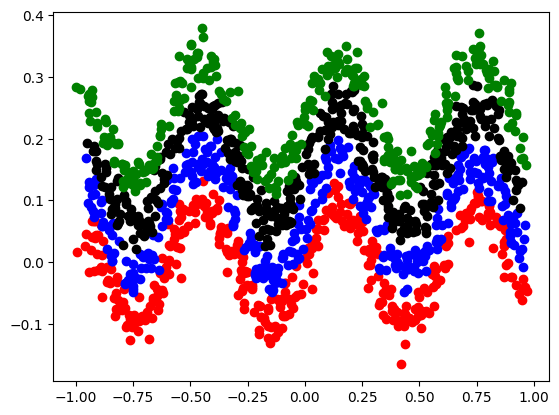

In [7]:
preds = net(torch.tensor(train_x)).detach().numpy()
preds = np.argmax(preds, axis=1)
plt.scatter(train_x[preds == 0, 0], train_x[preds == 0, 1], color='r')
plt.scatter(train_x[preds == 1, 0], train_x[preds == 1, 1], color='b')
plt.scatter(train_x[preds == 2, 0], train_x[preds == 2, 1], color='k')
plt.scatter(train_x[preds == 3, 0], train_x[preds == 3, 1], color='g')

In [8]:
test_x = torch.tensor(test_x) # convert from numpy data type to torch
test_y = torch.tensor(test_y)
# Testing with pytorch
preds = net(test_x)
print(preds[:5,:])
preds = torch.argmax(net(test_x), axis=1) # net(test_x) return matrix size of [number of test sample * number of labels]
print(preds - test_y)
print("Accuracy: %.5f" % (torch.sum(preds == test_y) / len(test_y)))

tensor([[-36.9057,   9.8353,  16.8062,  10.6406],
        [ 24.9748,  12.2059, -12.8109, -27.3281],
        [ 22.2849,  12.3755, -11.5314, -26.1093],
        [-35.5075,   8.5374,  15.8828,  12.0481],
        [-86.1300,  13.0179,  35.3389,  37.8630]], grad_fn=<SliceBackward0>)
tensor([ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0, -1,  1,  0,
         0,  0,  1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
   

In [9]:
net.forward_fc4(test_x[:5, :])

tensor([[-36.9057,   9.8353,  16.8062,  10.6406],
        [ 24.9748,  12.2059, -12.8109, -27.3281],
        [ 22.2849,  12.3755, -11.5314, -26.1093],
        [-35.5075,   8.5374,  15.8828,  12.0481],
        [-86.1300,  13.0179,  35.3389,  37.8630]], grad_fn=<SliceBackward0>)


In [10]:
p = 21888242871839275222246405745257275088548364400416034343698204186575808495617
k = 7 # For left shift / right shift purpose
scaling_factor = 2**k


class IntNet():
  """
  Recreate the original network but with integers
  """
  def np2circom(self, x, sf):
    """
    Converting a 1D vector or a 2D numpy matrix to integer matrix (Python List of List)
    This is done by calculating int(x * sf) % p
    """
    x_int = []
    if len(x.shape) == 1: # Vector
      x_int = [0 for i in range(len(x))]
      for r in range(len(x_int)):
          x_int[r] = int(x[r] * sf)
          x_int[r] = x_int[r] % p

    else: # 2D matrix
      x_int = [[0] * len(x[0]) for i in range(len(x))]
      for r in range(len(x_int)):
        for c in range(len(x_int[r])):
          x_int[r][c] = int(x[r,c] * sf)
          x_int[r][c] = x_int[r][c] % p

    return x_int


  def __init__(self, net, k):
    """
    net: original pytorch network model (floating points)
    k: number of bits for shifting / scaling
    """
    super().__init__()
    params = list(net.named_parameters()) # parameters, weights, bias, etc.
    params = [p.detach().numpy().T for _, p in params]
    self.k = k
    self.sf = 2**k
    self.fc1_w = self.np2circom(params[0], self.sf)
    self.fc1_b = self.np2circom(params[1], self.sf**2)
    self.fc2_w = self.np2circom(params[2], self.sf)
    self.fc2_b = self.np2circom(params[3], self.sf**2)
    self.fc3_w = self.np2circom(params[4], self.sf)
    self.fc3_b = self.np2circom(params[5], self.sf**2)
    self.fc4_w = self.np2circom(params[6], self.sf)
    self.fc4_b = self.np2circom(params[7], self.sf**2)


  def fc(self, x, w, b):
    """
    Fully connected layer using integer weights and inputs
    Since input (x) and weight (w) are scaled by sf
    The output needs to be divided by sf after the matrix mulitplication
    """
    assert len(x[1]) == len(w)
    out = [[0 for _ in range(len(w[0]))] for _ in range(len(x))]
    for i in range(len(out)):
      for j in range(len(out[0])):
        for k in range(len(x[0])):
          out[i][j] += x[i][k] * w[k][j]
        out[i][j] += b[j]
        out[i][j] = out[i][j] % p
        out[i][j] = out[i][j] - p if out[i][j] > p/2 else out[i][j]
        out[i][j] = (out[i][j] >> self.k) % p # Division by sf (2^k)
    return out


  def relu(self, x):
    out = [[0 for _ in x[0]] for _ in x]
    for i in range(len(x)):
      for j in range(len(x[0])):
        if x[i][j] < (p >> 1):
          out[i][j] = x[i][j]
    return out


  def forward_fc4(self, x):
    x = self.fc(x, self.fc1_w, self.fc1_b)
    x = self.relu(x)
    x = self.fc(x, self.fc2_w, self.fc2_b)

    x = self.relu(x)
    x = self.fc(x, self.fc3_w, self.fc3_b)
    # print()
    # x_ = x[:5]
    # for r in x_:
    #   x__ = [(c-p)/self.sf/self.sf if c > p/2 else c/self.sf/self.sf for c in r]
    #   print(x__)
    x = self.relu(x)
    x = self.fc(x, self.fc4_w, self.fc4_b)
    x_ = x[:5]
    for r in x_:
      x__ = [(c-p)/self.sf if c > p/2 else c/self.sf for c in r]
      print(x__)


  def forward(self, x):
    x = self.fc(x, self.fc1_w, self.fc1_b)
    x = self.relu(x)
    x = self.fc(x, self.fc2_w, self.fc2_b)
    x = self.relu(x)
    x = self.fc(x, self.fc3_w, self.fc3_b)
    x = self.relu(x)
    x = self.fc(x, self.fc4_w, self.fc4_b)
    return x


  def lessthan(self, x, y):
    if x < p / 2:
      if y < p / 2:
        return x < y
      else:
        return False
    else:
      if y > p / 2:
        return x < y
      else:
        return True


  def ff_argmax(self, x):
    """
    Finite field arg max
    """
    ind_arr = []
    for i in range(len(x)):
      max_val = x[i][0]
      max_ind = 0
      for j in range(len(x[0])):
        if self.lessthan(max_val, x[i][j]):
          max_val = x[i][j]
          max_ind = j
        # if (x[i][j] - max_val) < p / 2:
        #   max_val = x[i][j]
        #   max_ind = j
      ind_arr.append(max_ind)
    return ind_arr
  #def relu(self):

# Params for circom simulation
int_net = IntNet(net, k)

In [11]:
test_x_int = int_net.np2circom(test_x.numpy(), int_net.sf)
print(test_x.numpy()[0][0])
print((test_x_int[0][0] - p)/int_net.sf)
int_net.forward_fc4(test_x_int[:5])

-0.47702494
-0.4765625
[-35.453125, 9.5703125, 16.109375, 9.7578125]
[23.046875, 11.9375, -12.28125, -26.0]
[19.453125, 12.234375, -10.59375, -24.390625]
[-34.4375, 8.2734375, 15.109375, 11.6328125]
[-80.8203125, 12.3515625, 32.828125, 34.890625]


In [12]:
test_x_int = int_net.np2circom(test_x.numpy(), int_net.sf)
pred_int = int_net.forward(test_x_int)
print(pred_int[:5])

[[21888242871839275222246405745257275088548364400416034343698204186575808491079, 1225, 2062, 1249], [2950, 1528, 21888242871839275222246405745257275088548364400416034343698204186575808494045, 21888242871839275222246405745257275088548364400416034343698204186575808492289], [2490, 1566, 21888242871839275222246405745257275088548364400416034343698204186575808494261, 21888242871839275222246405745257275088548364400416034343698204186575808492495], [21888242871839275222246405745257275088548364400416034343698204186575808491209, 1059, 1934, 1489], [21888242871839275222246405745257275088548364400416034343698204186575808485272, 1581, 4202, 4466]]


In [13]:
# Calculating accuracy of model after scaling

pred = np.asarray(int_net.ff_argmax(pred_int), dtype=np.int32)
print(pred)
print(test_y.numpy())
print(pred - test_y.numpy())
print("Accuracy: %.5f" % (np.sum(pred == test_y.numpy()) / len(test_y.numpy())))

[2 0 0 2 3 0 2 3 0 3 3 0 1 0 2 2 3 0 1 3 1 1 2 2 2 1 2 0 1 3 0 2 3 1 1 2 2
 2 2 0 0 3 2 1 0 1 1 1 1 2 1 1 1 0 3 0 2 3 1 2 3 1 2 3 0 1 3 2 2 0 3 1 1 2
 1 3 1 3 2 0 2 1 0 2 1 3 1 0 2 3 3 0 3 3 3 2 3 3 1 1 3 3 1 0 1 1 1 1 0 1 0
 3 0 3 1 3 2 3 1 3 1 2 2 1 2 1 2 0 2 0 0 3 1 2 1 3 2 3 3 0 2 2 2 1 1 0 0 1
 2 1 3 2 0 3 0 0 2 1 3 1 3 0 2 0 0 1 1 1 0 0 1 1 3 3 3 3 0 1 0 2 2 3 2 2 1
 2 2 0 1 2 3 1 1 2 1 2 0 0 2 1 1 2 3 1 2 1 3 1 3 3 2 1 1 2 3 3 1 3 0 0 0 1
 0 1 1 3 1 2 2 1 2 1 3 3 1 2 1 0 3 0 0 2 0 2 1 2 2 0 2 2 0 3 3 0 0 0 1 2 2
 3 1 0 2 0 1 0 0 3 1 3 0 1 1 3 0 0 1 1 1 1 2 3 0 2 3 0 2 2 3 3 2 2 1 1 2 0
 0 1 1 3 1 2 1 2 1 2 0 2 3 3 2 0 3 3 2 1 0 0 3 2 2 1 0 2 1 0 2 1 3 0 2 0 0
 2 1 1 2 1 3 1 3 0 2 0 2 2 3 0 2 1 1 2 0 1 3 1 2 0 2 3 3 3 2 1 0 3 3 0 2 0
 1 3 3 0 2 1 2 1 0 1 1 1 3 0 2 2 2 0 3 3 2 0 2 1 1 1 3 2 0 0 2 1 0 1 2 2 2
 2 2 1 2 0 2 0 2 1 0 1 1 0 3 3 0 2 1 0 2 2 0 3 3 0 2 1 0 0 1 2 3 0 1 1 0 1
 2 2 0 0 0 3 2 0 3 2 2 3 1 0 1 2 1 3 2 1 0 3 2 3 0 1 2 2 2 1 3 3 3 2 1 0 2
 1 3 0 0 1 3 2 3 2 0 2 2 

In [14]:
def transpose_list(x):
  output = [[0 for _ in range(len(x))] for _ in range(len(x[0]))]
  for i in range(len(x)):
    for j in range(len(x[0])):
      output[j][i] = x[i][j]
  return output

In [15]:
in_json = {
    "in": test_x_int,
    "w1": transpose_list(int_net.fc1_w),
    "b1": int_net.fc1_b,
    "w2": transpose_list(int_net.fc2_w),
    "b2": int_net.fc2_b,
    "w3": transpose_list(int_net.fc3_w),
    "b3": int_net.fc3_b,
    "w4": transpose_list(int_net.fc4_w),
    "b4": int_net.fc4_b,
    "out": pred_int,
    "k": k
}

In [16]:
import json
with open("fc_integer_test.json", "w") as f:
    json.dump(in_json, f)